In [1]:
!apt install tesseract-ocr -y
!pip install opencv-python pytesseract nltk scikit-learn wordcloud


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [7]:
from google.colab import files
uploaded = files.upload()


Saving sample4.jpg to sample4.jpg


In [8]:
import cv2
import pytesseract
import numpy as np

pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"

# Load image
img = cv2.imread("sample4.jpg")
if img is None:
    raise FileNotFoundError("Image not found")

# Preprocessing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)

_, thresh = cv2.threshold(
    gray, 0, 255,
    cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
dilation = cv2.dilate(thresh, kernel, iterations=1)

contours, _ = cv2.findContours(
    dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

extracted_text = ""

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cropped = img[y:y+h, x:x+w]
    text = pytesseract.image_to_string(cropped, config="--psm 6")
    extracted_text += text.strip() + " "

print("RAW OCR OUTPUT:\n", extracted_text)


RAW OCR OUTPUT:
 This is SAMPLE TEXT
Text is at different regions 


In [9]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return " ".join(tokens)

cleaned_text = clean_text(extracted_text)

print("CLEANED TEXT:\n", cleaned_text)


CLEANED TEXT:
 sample text text different regions


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

words = cleaned_text.split()
word_freq = Counter(words)

df_freq = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
df_freq = df_freq.sort_values(by='Frequency', ascending=False)

df_freq.head(10)


,Word,Frequency
1,text,2
0,sample,1
2,different,1
3,regions,1


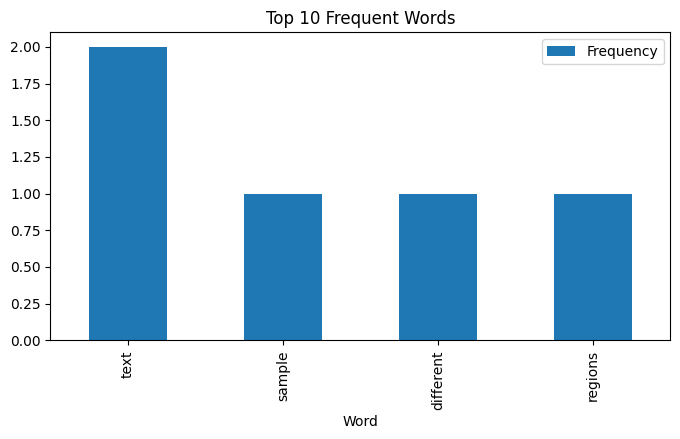

In [11]:
df_freq.head(10).plot(
    x='Word', y='Frequency',
    kind='bar', figsize=(8,4),
    title='Top 10 Frequent Words'
)
plt.show()


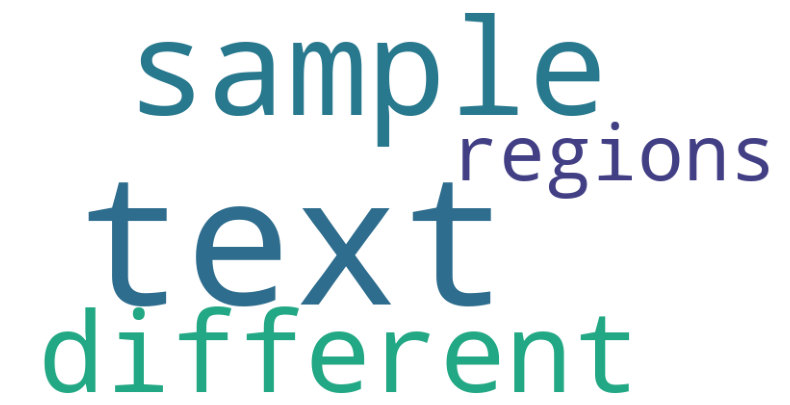

In [12]:
from wordcloud import WordCloud

wc = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(cleaned_text)

plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [cleaned_text]

vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(corpus)

keywords = vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray()[0]

tfidf_df = pd.DataFrame({
    'Keyword': keywords,
    'Score': scores
}).sort_values(by='Score', ascending=False)

tfidf_df


,Keyword,Score
3,text,0.755929
0,different,0.377964
1,regions,0.377964
2,sample,0.377964


In [14]:
with open("extracted_text.txt", "w") as f:
    f.write(extracted_text)

with open("cleaned_text.txt", "w") as f:
    f.write(cleaned_text)

df_freq.to_csv("word_frequency.csv", index=False)
tfidf_df.to_csv("keywords.csv", index=False)

print("All outputs saved successfully.")


All outputs saved successfully.
